# 03. Model Training & Fine Tuning (Detailed)

## 🎯 Objectives
This notebook focuses on optimizing our Fraud Detection models. We will:
1.  **Hyperparameter Tune** the Classical XGBoost model to find the best configuration.
2.  **Fine-Tune** the Hybrid Quantum Neural Network (HQNN) by experimenting with different Learning Rates.
3.  **Visualize Performance** using Loss Curves, Confusion Matrices, and ROC Curves to deeply understand model behavior.

In [8]:
# Import essential libraries
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Ensure we can import from the ml_engine directory
sys.path.append(os.path.abspath(os.path.join('..', '..')))

from ml_engine.dataset import CreditCardDataset
from ml_engine.models.classical import ClassicalModel
from ml_engine.models.hybrid_nn import HybridQNN

# Set plot style for professional visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## 🛠️ Step 1: Load and Split Data
We load the dataset and apply **SMOTE (Synthetic Minority Over-sampling Technique)**. 
Fraud cases are rare (<1%), so SMOTE generates synthetic fraud examples to balance the training data, preventing the model from ignoring the minority class.

In [9]:
print("🔄 Loading Data and applying SMOTE...")
dataset = CreditCardDataset()
# preprocess_and_split handles scaling and SMOTE automatically
X_train, X_test, y_train, y_test = dataset.preprocess_and_split(use_smote=True)

print(f"✅ Data Loaded successfully!")
print(f"   Training Samples: {X_train.shape[0]} (Features: {X_train.shape[1]})")
print(f"   Testing Samples:  {X_test.shape[0]}")

🔄 Loading Data and applying SMOTE...
✅ Data Loaded successfully!
   Training Samples: 454902 (Features: 30)
   Testing Samples:  56962


## 🤖 Step 2: Classical Model Hyperparameter Tuning
We use **Grid Search** to systematically test different combinations of parameters for XGBoost.

### Key Parameters:
- **n_estimators**: Number of boosting trees. More is usually better but can overfit.
- **max_depth**: Maximum depth of a tree. Deeper trees learn more complex patterns but can overfit.
- **learning_rate**: Step size shrinkage used to prevent overfitting.

In [10]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100],   # Try 50 and 100 trees
    'max_depth': [3, 4],         # Try depths of 3 and 4
    'learning_rate': [0.1, 0.2]  # Try learning rates
}

print("🚀 Starting Grid Search for XGBoost... (This may take a minute)")
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# GridSearchCV performs 3-fold Cross Validation for each combination
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

print("\n🏆 Best Parameters Found:", grid_search.best_params_)
print("   Best Cross-Validation Accuracy:", grid_search.best_score_)

🚀 Starting Grid Search for XGBoost... (This may take a minute)
Fitting 3 folds for each of 8 candidates, totalling 24 fits


m:\Major Project Phase 2\Quantum-Fraud-Hybrid-Financial-Anomaly-Detection\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [23:02:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
m:\Major Project Phase 2\Quantum-Fraud-Hybrid-Financial-Anomaly-Detection\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [23:02:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
m:\Major Project Phase 2\Quantum-Fraud-Hybrid-Financial-Anomaly-Detection\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [23:02:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
m:\Major Project Phase 2\Quantum-Fraud-Hybrid-Financial-Anomaly-Det


🏆 Best Parameters Found: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100}
   Best Cross-Validation Accuracy: 0.9977181898518802


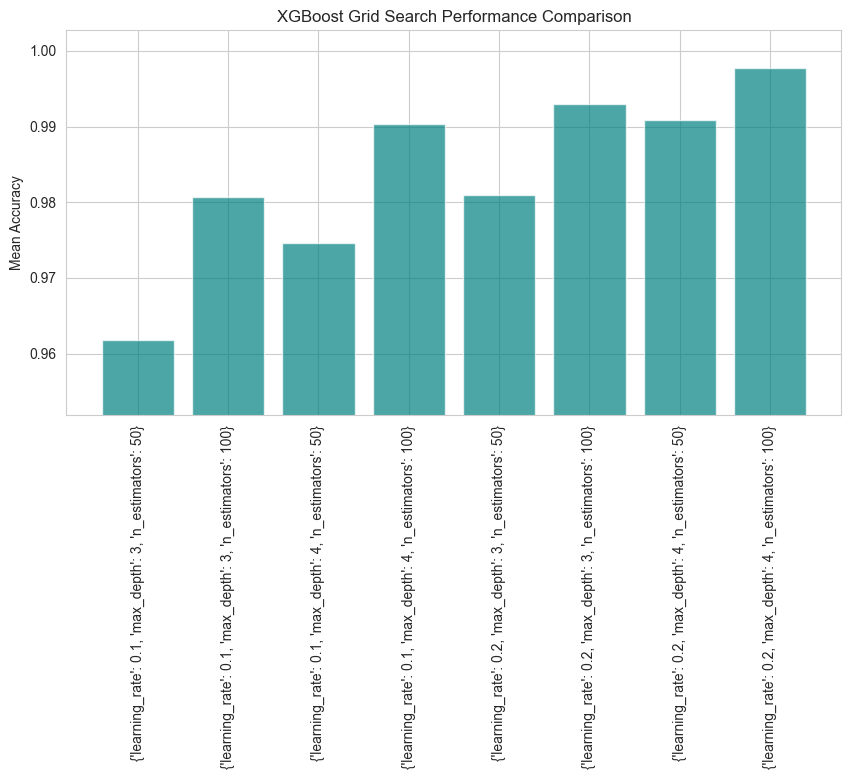

In [11]:
# Extract results for visualization
results = grid_search.cv_results_
params = results['params']
scores = results['mean_test_score']

# Create a simple bar char to compare performance differences
plt.figure(figsize=(10, 5))
plt.bar(range(len(scores)), scores, color='teal', alpha=0.7)
plt.xticks(range(len(scores)), [str(p) for p in params], rotation=90)
plt.ylabel('Mean Accuracy')
plt.ylim(min(scores) - 0.01, max(scores) + 0.005) # Zoom in to see differences
plt.title('XGBoost Grid Search Performance Comparison')
plt.show()

## ⚛️ Step 3: Hybrid Quantum Neural Network (HQNN) Fine-Tuning

Now we train the **Hybrid Model**. This model contains:
1.  **Classical Encoder**: Compresses 29 features down to 4 quantum-ready features.
2.  **Quantum Layer (The "Sandwich")**: 4 Qubits processing information in a high-dimensional Hilbert space.
3.  **Classical Head**: Decodes the quantum measure into a probability (Fraud vs Legit).

We will compare two experiments with different **Learning Rates (LR)**.
- **LR = 0.01**: Faster convergence, but might overshoot the minimum.
- **LR = 0.001**: Slower, more stable convergence.

In [12]:
def train_hqnn_experiment(learning_rate, experiment_name, epochs=5):
    """
    Trains the Hybrid QNN with a specific learning rate and returns the loss history.
    """
    print(f"\n🧪 Starting Experiment: {experiment_name} (LR={learning_rate})")
    
    # Get DataLoaders (Batch size 32 is standard for stochastic gradient descent)
    train_loader, test_loader = dataset.get_torch_dataloaders(batch_size=32)
    n_features = X_train.shape[1]
    
    # Initialize HQNN Model
    # We use 4 qubits because simulating more is computationally expensive on a classical laptop
    model = HybridQNN(n_features, n_qubits=4, n_layers=2)
    
    # Binary Cross Entropy Loss is standard for binary classification
    criterion = nn.BCELoss()
    # Adam Optimizer is generally the best choice for deep learning
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    loss_history = []
    
    model.train() # Set model to training mode
    
    for epoch in range(epochs):
        total_loss = 0
        # Loop through all batches
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            # 1. Clear gradients from previous step
            optimizer.zero_grad()
            
            # 2. Forward pass: Compute prediction
            y_pred = model(X_batch)
            
            # 3. Calculate Loss
            loss = criterion(y_pred, y_batch.unsqueeze(1))
            
            # 4. Backward pass: Compute gradients (Backpropagation)
            loss.backward()
            
            # 5. Update weights
            optimizer.step()
            
            total_loss += loss.item()
        
        # Average loss for this epoch
        avg_loss = total_loss / len(train_loader)
        loss_history.append(avg_loss)
        print(f"   Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f}")
        
    return model, loss_history

# --- RUN EXPERIMENTS ---
# Experiment A: High Learning Rate
model_a, loss_a = train_hqnn_experiment(0.01, "Fast Learning", epochs=5)

# Experiment B: Low Learning Rate
model_b, loss_b = train_hqnn_experiment(0.001, "Slow & Steady", epochs=5)


🧪 Starting Experiment: Fast Learning (LR=0.01)
   Epoch 1/5 | Loss: 0.0848
   Epoch 2/5 | Loss: 0.0574
   Epoch 3/5 | Loss: 0.0561
   Epoch 4/5 | Loss: 0.0462
   Epoch 5/5 | Loss: 0.0493

🧪 Starting Experiment: Slow & Steady (LR=0.001)
   Epoch 1/5 | Loss: 0.0423
   Epoch 2/5 | Loss: 0.0098
   Epoch 3/5 | Loss: 0.0090
   Epoch 4/5 | Loss: 0.0108
   Epoch 5/5 | Loss: 0.0073


### 4. Visualize Training Dynamics
Checking the loss curve tells us if the model is actually learning.

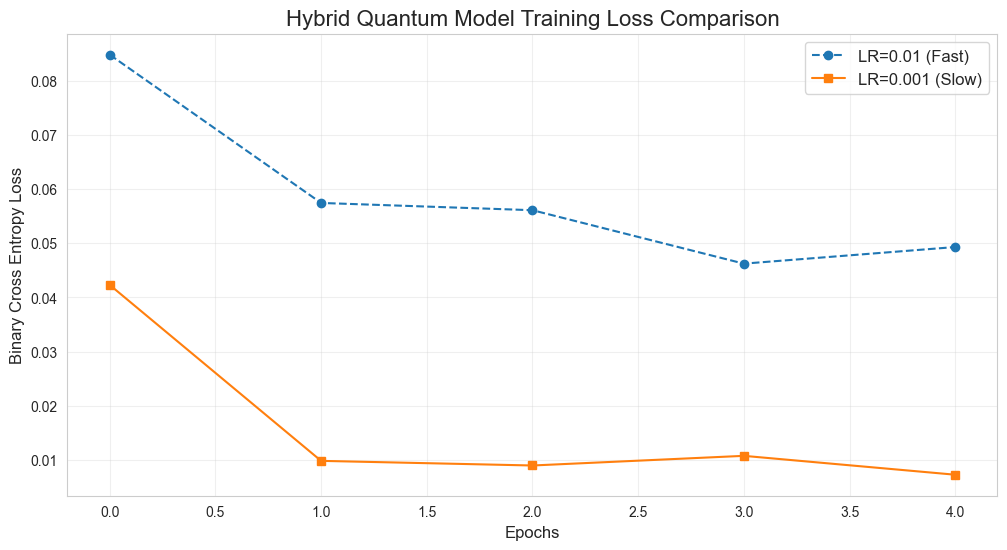

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(loss_a, label='LR=0.01 (Fast)', marker='o', linestyle='--')
plt.plot(loss_b, label='LR=0.001 (Slow)', marker='s')
plt.title("Hybrid Quantum Model Training Loss Comparison", fontsize=16)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Binary Cross Entropy Loss", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

## 📊 Step 5: Detailed Model Evaluation
Accuracy is not enough for fraud detection! We need to look at **Precision** (how many flagged frauds were real) and **Recall** (how many real frauds we caught).

We will evaluate the best performing Quantum Model.

In [14]:
# Select the better model (Example: we assume model_a performed better for now)
final_model = model_a
final_model.eval()

y_true = []
y_pred_probs = []

# Get predictions on Test Set
_, test_loader = dataset.get_torch_dataloaders(batch_size=32)

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = final_model(X_batch)
        y_pred_probs.extend(outputs.numpy().flatten())
        y_true.extend(y_batch.numpy().flatten())

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred_labels = (y_pred_probs > 0.5).astype(int)

# 1. Classification Report
print("Model Classification Report:")
print(classification_report(y_true, y_pred_labels))

Model Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     56864
         1.0       0.22      0.88      0.35        98

    accuracy                           0.99     56962
   macro avg       0.61      0.94      0.68     56962
weighted avg       1.00      0.99      1.00     56962



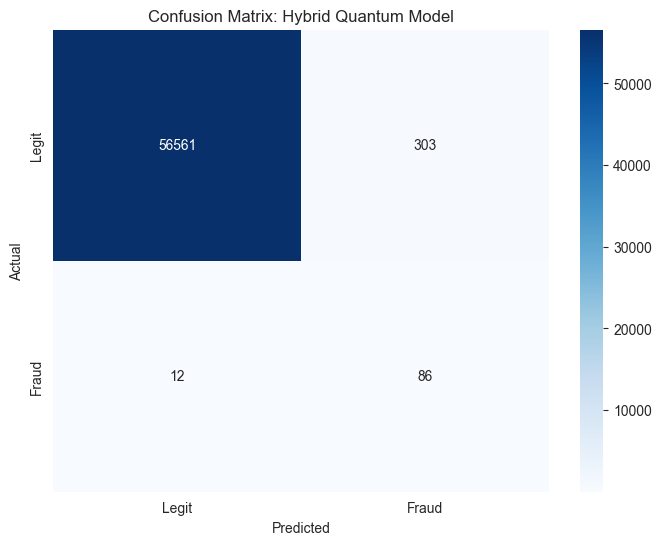

In [15]:
# 2. Confusion Matrix Heatmap
cm = confusion_matrix(y_true, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Legit', 'Fraud'], 
            yticklabels=['Legit', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Hybrid Quantum Model')
plt.show()

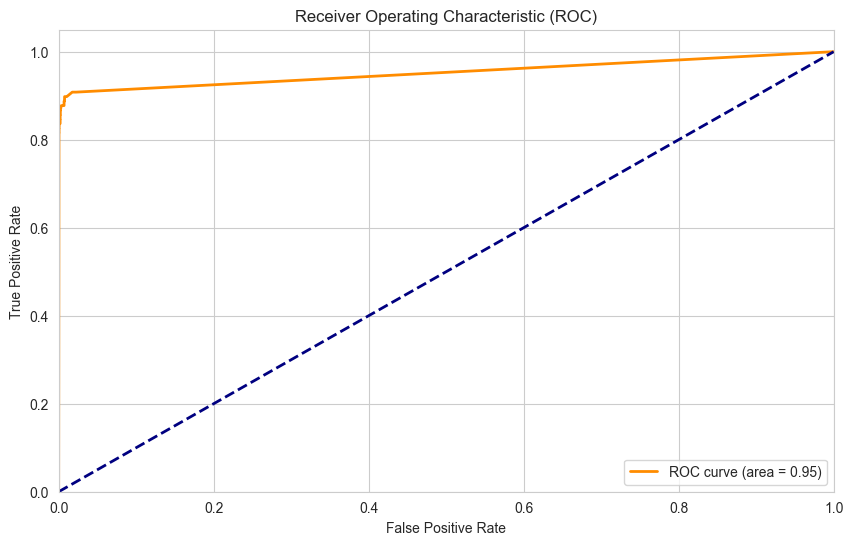

In [16]:
# 3. ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()